In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import the pipelines from the regression_pipelines module
from Regression_Model_Pipeline import create_preprocessor, create_pipelines, tune_models, evaluate_models, create_and_fit_model  
import warnings                               #ignore warnings
warnings. filterwarnings("ignore")
import seaborn as sns                         #data visualization
import matplotlib.pyplot as plt               #data visualization
from sklearn.model_selection import GridSearchCV

In [26]:
#Load your dataset
# data = pd.read_csv("https://static.bc-edx.com/ai/ail-v-1-0/m12/lesson_1/datasets/car-data-encoded.csv")
data = pd.read_csv('garments_worker_productivity.csv')
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [27]:
# Make a copy of the original data
data_copy = data.copy()
# Convert the 'date' column to datetime objects
data_copy['date'] = pd.to_datetime(data_copy['date'])

# Calculate the mean of the 'wip' column
mean_wip = data_copy['wip'].mean()

# Fill missing values in 'wip' with the mean
data_copy['wip'].fillna(value=mean_wip, inplace=True)

In [28]:
print(data_copy.isnull().sum())

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64


In [29]:
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = data.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = data[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# Drop the target column from the copy
data_copy = data_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = data_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor
preprocessor = create_preprocessor(categorical_features, numerical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']


In [31]:
# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(preprocessor, models)

In [32]:
metrics_df = evaluate_models(pipelines, X_train, y_train, X_test, y_test)

                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Linear Regression                0.337682       0.170761             0.111072            0.023351  0.170761
Lasso Regression                 0.000000      -0.000685             0.128256            0.028178 -0.000685
Ridge Regression                 0.337652       0.172310             0.110871            0.023307  0.172310
Random Forest Regression         0.934232       0.459584             0.076244            0.015218  0.459584
Support Vector Regression        0.612984       0.303764             0.099330            0.019605  0.303764
Elastic Net                      0.000000      -0.000685             0.128256            0.028178 -0.000685
Decision Tree Regression         1.000000       0.135068             0.092918            0.024356  0.135068
Gradient Boost Regression        0.691740       0.422057             0.082626            0.016274  0.422057
KNeighbors Regression       

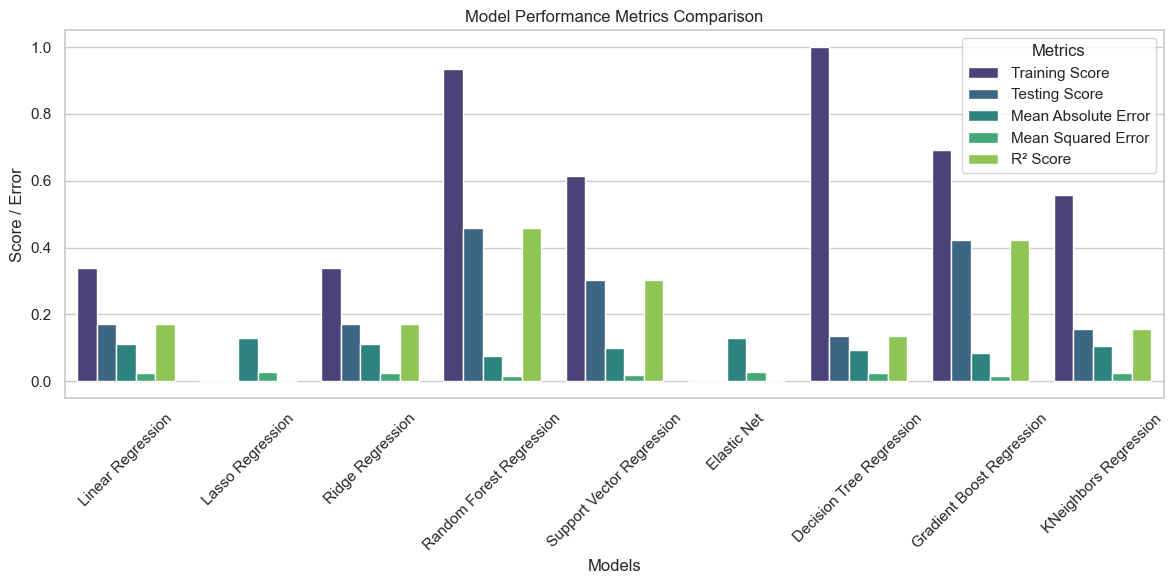

In [33]:
# Convert the dictionary to a DataFrame
# metrics_df = pd.DataFrame(performance_metrics).T

# Reset the index to have model names as a column
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

# Melt the DataFrame for better plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')

# Customize the plot
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score / Error')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

# Show the plot
plt.tight_layout()
plt.show()

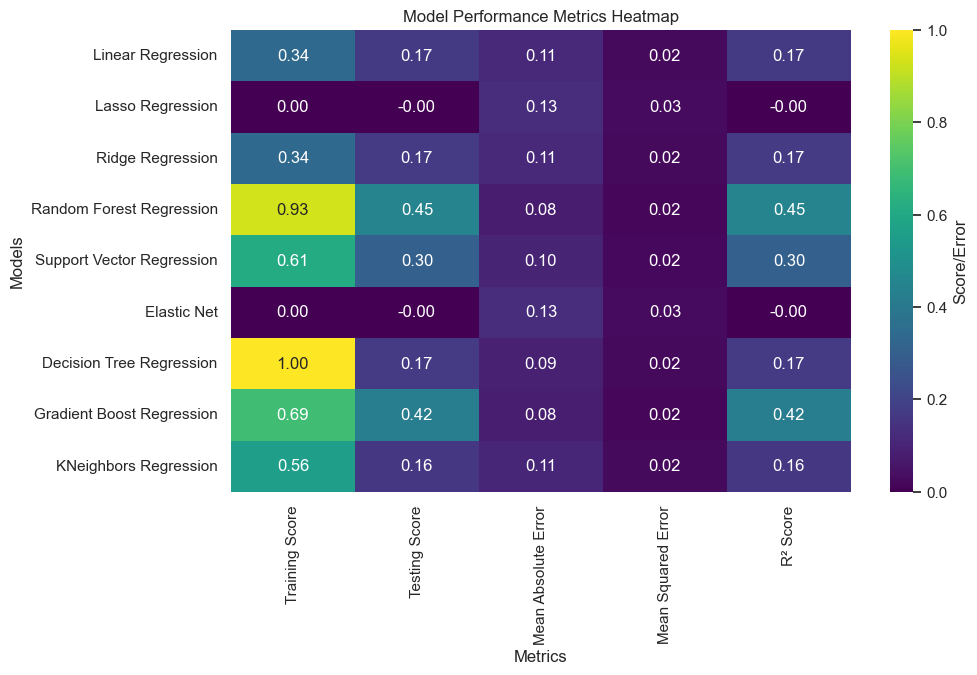

In [35]:
# This will drop any non-numeric columns (like model names)
# metrics_df = performance_df.drop(columns=['Training Score', 'Testing Score'])  # Adjust as necessary

# Create a heatmap
metrics_df = performance_df[['Training Score', 'Testing Score', 'Mean Absolute Error', 'Mean Squared Error', 'R² Score']]

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Score/Error'})

# Customize the plot
plt.title('Model Performance Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

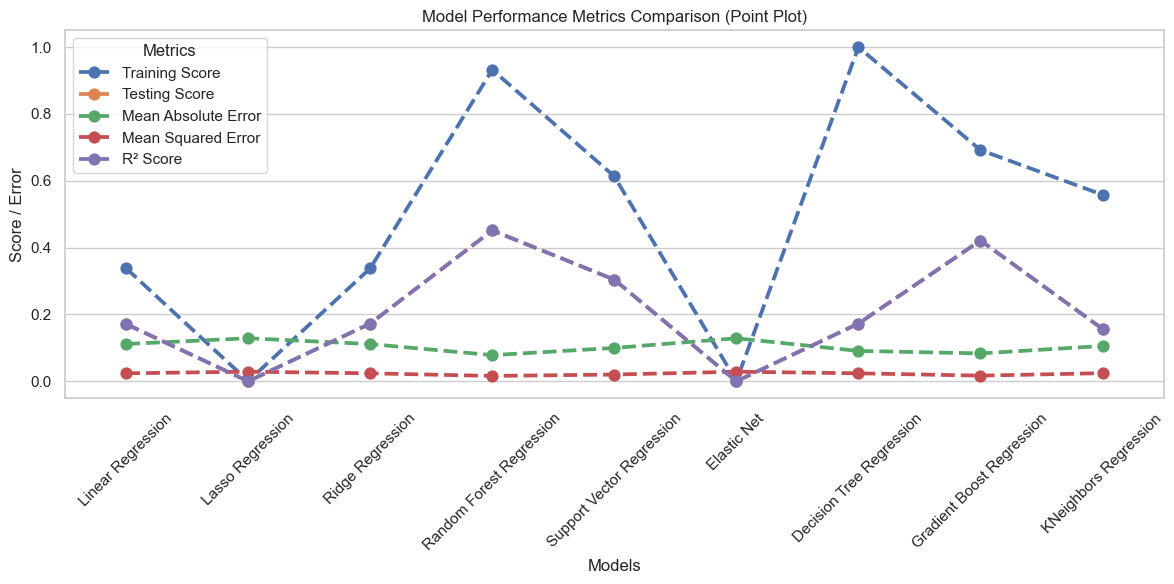

In [36]:
# Melt the DataFrame for better plotting
metrics_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_melted.rename(columns={'index': 'Model'}, inplace=True)

# Create a point plot
plt.figure(figsize=(12, 6))
sns.pointplot(x='Model', y='Score', hue='Metric', data=metrics_melted, markers='o', linestyles='--')

# Customize the plot
plt.title('Model Performance Metrics Comparison (Point Plot)')
plt.ylabel('Score / Error')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

# Show the plot
plt.tight_layout()
plt.show()

## This Section is Hyper Parameter Tuning for Models to Try to Improve Model Score

In [37]:
# Define parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Lasso Regression': {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'Ridge Regression': {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'Random Forest Regression': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2],
        'regressor__max_features': ['auto', 'sqrt']
    },
    'Support Vector Regression': {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.1, 0.2, 0.5]
    },
    'Elastic Net': {
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Decision Tree Regression': {
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    'Gradient Boost Regression': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    },
    'KNeighbors Regression': {
        'regressor__n_neighbors': [3, 5, 10],
        'regressor__weights': ['uniform', 'distance']
    }
}

tuning_results = tune_models(pipelines, param_grids, X_train, y_train)

# Print tuning results
print("\nTuning Results:")
print("=" * 50)  # Separator line
for model_name, result in tuning_results.items():
    best_params = result['best_params']
    best_score = result['best_score']
    
    # Format the parameters for better readability
    params_str = ', '.join([f"{key}: {value}" for key, value in best_params.items()])
    
    print(f"Model: {model_name}")
    print(f"  Best Parameters: {params_str}")
    print(f"  Best Score (Neg MSE): {best_score:.4f}")
    print("-" * 50)  # Separator line

Tuning Linear Regression...
Tuning Lasso Regression...
Tuning Ridge Regression...
Tuning Random Forest Regression...
Tuning Support Vector Regression...
Tuning Elastic Net...
Tuning Decision Tree Regression...
Tuning Gradient Boost Regression...
Tuning KNeighbors Regression...

Tuning Results:
Model: Linear Regression
  Best Parameters: 
  Best Score (Neg MSE): -0.0247
--------------------------------------------------
Model: Lasso Regression
  Best Parameters: regressor__alpha: 0.01
  Best Score (Neg MSE): -0.0236
--------------------------------------------------
Model: Ridge Regression
  Best Parameters: regressor__alpha: 10.0
  Best Score (Neg MSE): -0.0219
--------------------------------------------------
Model: Random Forest Regression
  Best Parameters: regressor__max_depth: 20, regressor__max_features: sqrt, regressor__min_samples_leaf: 1, regressor__min_samples_split: 5, regressor__n_estimators: 200
  Best Score (Neg MSE): -0.0150
---------------------------------------------

In [38]:
fitted_models = {}

for model_name, result in tuning_results.items():
    best_params = result['best_params']
    fitted_model = create_and_fit_model(model_name, best_params, X_train, y_train, pipelines)
    fitted_models[model_name] = fitted_model  # Store the fitted model

In [39]:
fitted_metrics_df = evaluate_models(fitted_models, X_train, y_train, X_test, y_test)

                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Linear Regression                0.337682       0.170761             0.111072            0.023351  0.170761
Lasso Regression                 0.254333       0.170077             0.109296            0.023370  0.170077
Ridge Regression                 0.335841       0.180753             0.109583            0.023069  0.180753
Random Forest Regression         0.820722       0.441496             0.083107            0.015727  0.441496
Support Vector Regression        0.612984       0.303764             0.099330            0.019605  0.303764
Elastic Net                      0.330141       0.189999             0.108363            0.022809  0.189999
Decision Tree Regression         0.791896       0.200346             0.089430            0.022518  0.200346
Gradient Boost Regression        0.765897       0.401627             0.083910            0.016850  0.401627
KNeighbors Regression       

In [40]:
print("Original Metrics DataFrame Columns:", metrics_df.columns)
print("Fitted Metrics DataFrame Columns:", fitted_metrics_df.columns)

Original Metrics DataFrame Columns: Index(['Training Score', 'Testing Score', 'Mean Absolute Error',
       'Mean Squared Error', 'R² Score'],
      dtype='object')
Fitted Metrics DataFrame Columns: Index(['Training Score', 'Testing Score', 'Mean Absolute Error',
       'Mean Squared Error', 'R² Score'],
      dtype='object')


In [42]:
# Combine original and fitted metrics into a single DataFrame for comparison
comparison_df = pd.concat([metrics_df, fitted_metrics_df], axis=1)

# Create a multi-level column index
comparison_df.columns = pd.MultiIndex.from_tuples([
    ('Original', 'Training Score'),
    ('Original', 'Testing Score'),
    ('Original', 'MAE'),
    ('Original', 'MSE'),
    ('Original', 'R² Score'),
    ('Fitted', 'Training Score'),
    ('Fitted', 'Testing Score'),
    ('Fitted', 'MAE'),
    ('Fitted', 'MSE'),
    ('Fitted', 'R² Score'),
])

# Display the comparison DataFrame
print(comparison_df.to_string(index=True))

                                Original                                                     Fitted                                            
                          Training Score Testing Score       MAE       MSE  R² Score Training Score Testing Score       MAE       MSE  R² Score
Linear Regression               0.337682      0.170761  0.111072  0.023351  0.170761       0.337682      0.170761  0.111072  0.023351  0.170761
Lasso Regression                0.000000     -0.000685  0.128256  0.028178 -0.000685       0.254333      0.170077  0.109296  0.023370  0.170077
Ridge Regression                0.337652      0.172310  0.110871  0.023307  0.172310       0.335841      0.180753  0.109583  0.023069  0.180753
Random Forest Regression        0.932240      0.451192  0.077740  0.015454  0.451192       0.820722      0.441496  0.083107  0.015727  0.441496
Support Vector Regression       0.612984      0.303764  0.099330  0.019605  0.303764       0.612984      0.303764  0.099330  0.019605  0

In [44]:
print(comparison_flat.columns)

MultiIndex([(   'index',               ''),
            ('Original', 'Training Score'),
            ('Original',  'Testing Score'),
            ('Original',            'MAE'),
            ('Original',            'MSE'),
            ('Original',       'R² Score'),
            (  'Fitted', 'Training Score'),
            (  'Fitted',  'Testing Score'),
            (  'Fitted',            'MAE'),
            (  'Fitted',            'MSE'),
            (  'Fitted',       'R² Score')],
           )


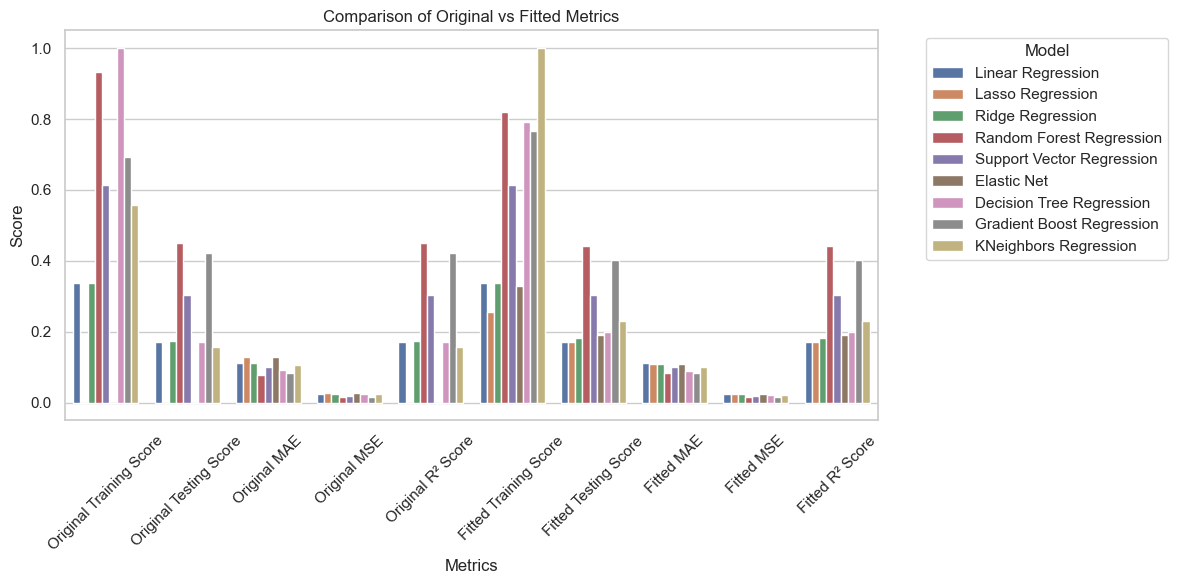

In [46]:
# Assuming comparison_df is your DataFrame with multi-level columns
# Reset the index to have a flat DataFrame for plotting
comparison_flat = comparison_df.reset_index()

# Flatten the MultiIndex columns
comparison_flat.columns = ['Model'] + [f'{level_0} {level_1}' for level_0, level_1 in comparison_flat.columns[1:]]

# Melt the DataFrame to long format for Seaborn
comparison_melted = comparison_flat.melt(id_vars='Model', var_name='Metric Type', value_name='Score')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='Metric Type', y='Score', hue='Model', ci=None)

# Customize the plot
plt.title('Comparison of Original vs Fitted Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout for better fit
plt.show()

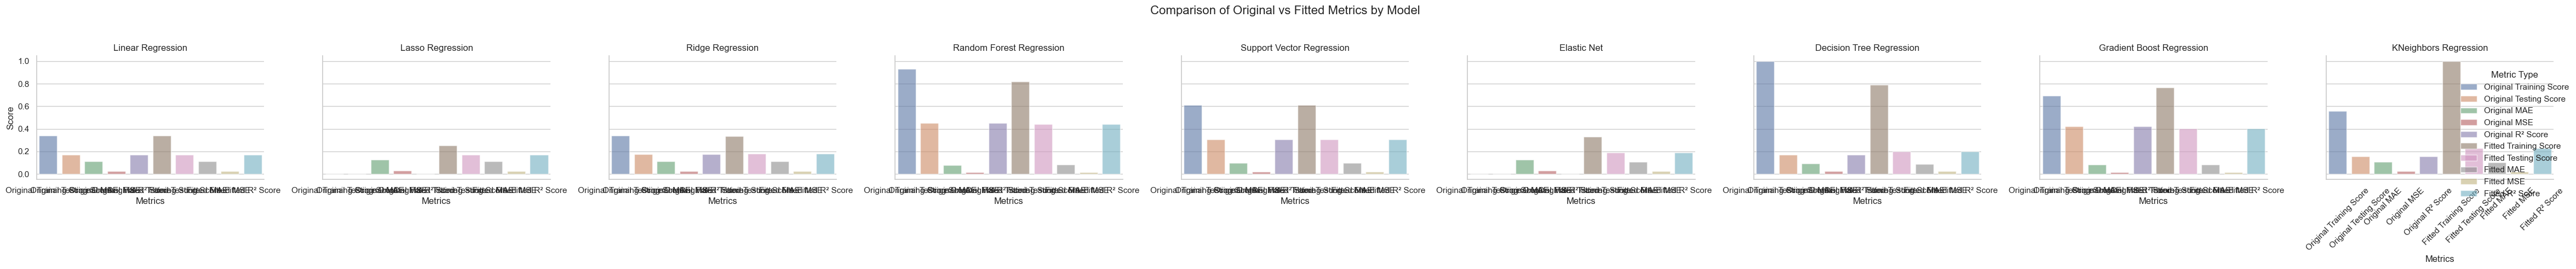

In [52]:
# Reset the index to have a flat DataFrame for plotting
comparison_flat = comparison_df.reset_index()

# Flatten the MultiIndex columns
comparison_flat.columns = ['Model'] + [f'{level_0} {level_1}' for level_0, level_1 in comparison_flat.columns[1:]]

# Melt the DataFrame to long format for Seaborn
comparison_melted = comparison_flat.melt(id_vars='Model', var_name='Metric Type', value_name='Score')

# Create a FacetGrid to plot separate graphs for each model
g = sns.FacetGrid(comparison_melted, col='Model', hue='Metric Type', height=5, aspect=1)

# Map a bar plot to each facet
g.map(sns.barplot, 'Metric Type', 'Score', alpha=0.6)

# Add titles and adjust the layout
g.add_legend(title='Metric Type')
g.set_axis_labels('Metrics', 'Score')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Comparison of Original vs Fitted Metrics by Model', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

ValueError: Could not interpret value `Metric Type` for `hue`. Value is a string, but `data` was not passed.

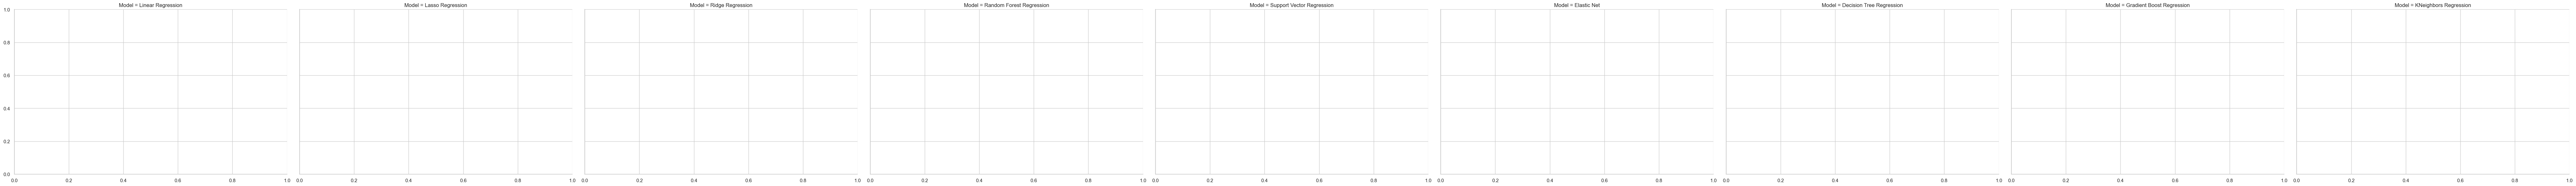

In [58]:

# Combine original and fitted metrics into a single DataFrame for comparison
comparison_df = pd.concat([metrics_df, fitted_metrics_df], axis=1)

# Create a multi-level column index
comparison_df.columns = pd.MultiIndex.from_tuples([
    ('Original', 'Training Score'),
    ('Original', 'Testing Score'),
    ('Original', 'MAE'),
    ('Original', 'MSE'),
    ('Original', 'R² Score'),
    ('Fitted', 'Training Score'),
    ('Fitted', 'Testing Score'),
    ('Fitted', 'MAE'),
    ('Fitted', 'MSE'),
    ('Fitted', 'R² Score'),
])

# Reset the index to have a flat DataFrame for plotting
comparison_flat = comparison_df.reset_index()

# Flatten the MultiIndex columns
comparison_flat.columns = ['Model'] + [f'{level_0} {level_1}' for level_0, level_1 in comparison_flat.columns[1:]]

# Melt the DataFrame to long format for Seaborn
comparison_melted = comparison_flat.melt(id_vars='Model', var_name='Metric Type', value_name='Score')

# Create a FacetGrid to plot separate graphs for each model
g = sns.FacetGrid(comparison_melted, col='Model', height=6, aspect=1.5)

# Map a bar plot to each facet
g.map(sns.barplot, 'Metric Type', 'Score', hue='Metric Type', alpha=0.6)

# Customize the plot
g.add_legend(title='Metric Type')
g.set_axis_labels('Metrics', 'Score')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Comparison of Original vs Fitted Metrics by Model', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()